In [ ]:
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt

# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
         
# Verify Reading Dataset via MnistDataloader class
# Set file paths based on added MNIST Datasets
input_path = './data/mnist/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [2]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt

<class 'list'>


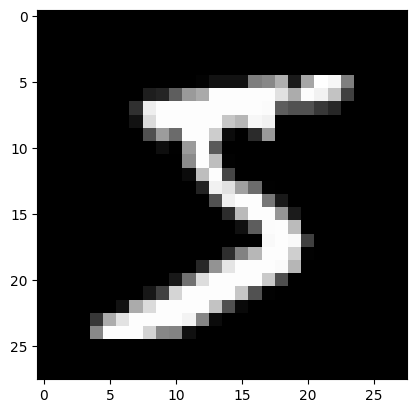

In [11]:
# from torch.utils.data import DataLoader
input_path = './data/mnist/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print(type(x_train[0]))
plt.imshow(x_train[0], cmap='gray')

In [40]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),  # Ensure fast so no action is needed
])

# Fetch the dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Subtract max(z) for numerical stability
    return exp_z / exp_z.sum(axis=-1, keepdims=True)
    
def softmax_derivative(softmax_output):
    # Reshape the softmax output into a column vector if it's 1D
    s = softmax_output.reshape(-1, 1)
    # Compute the Jacobian matrix: diag(s) - s * s.T
    jacobian_matrix = np.diagflat(s) - np.dot(s, s.T)
    return jacobian_matrix

def cross_entropy_loss(y, y_hat):
    # Small epsilon added to avoid log(0)
    epsilon = 1e-12
    y_hat = np.clip(y_hat, epsilon, 1. - epsilon)  # Ensure y_hat is within (0, 1) to prevent log(0)
    
    # Compute cross-entropy
    return -np.sum(y * np.log(y_hat)) / y.shape[0]  # Average over the batch

def cross_entropy_loss_prime(y, y_hat):
    return y_hat - y

def evaluate(model, data_loader):
    total_loss = 0
    correct = 0
    for X_val, y_val in data_loader:
        _, _, _, y_pred = model.forward(X_val)
        y_onehot = np.eye(10)[y_val]
        loss = cross_entropy_loss(y_onehot, y_pred)
        total_loss += loss

        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_onehot, axis=1)
        correct += np.sum(y_pred_classes == y_true)
   
    accuracy = correct / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss

class FCNetwork():
    """Single hidden layer network"""
    def __init__(self, input_dim, hidden_dim, output_dim, activation=sigmoid):
        self.w1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(1. / input_dim) # (d, h)
        self.w2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(1. / hidden_dim) # (h, 10)
        self.b1 = np.random.rand(1, hidden_dim) # (1, h)
        self.b2 = np.random.rand(1, output_dim) # (1, 10)
        self.activation = activation
        pass

    def forward(self, X):
        batch_size = X.shape[0]
        X = X.reshape((batch_size, -1))
        z1 = np.dot(X, self.w1) + self.b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, self.w2) + self.b2
        y_hat = sigmoid(z2)
        return z1, a1, z2, y_hat
    
    def predict(self, X):
        _, _, _, y_hat = self.forward(X)
        y_pred = np.argmax(y_hat, axis=1)
        return y_pred

    def compute_grad(self, X, y, y_hat, z1, a1, z2):
        batch_size = X.shape[0]
        X = X.reshape((batch_size, -1))

        # Output layer grads
        dz2 = y_hat - y
        dw2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True) / batch_size # sum over sammples

        # Hidden layer grads 
        dz1 = np.dot(dz2, self.w2.T) * sigmoid_derivative(z1)
        dw1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True) / batch_size # sum over sammples

        return dw1, db1, dw2, db2
    
    def update_weights(self, dw1, db1, dw2, db2, lr):
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        self.w2 -= lr * dw2
        self.b2 -= lr * db2

def train(train_data: DataLoader, val_data: DataLoader):
    # Initialize the weights
    lr = 0.01
    input_dim = 28 * 28
    hidden_dim = 256
    output_dim = 10
    model = FCNetwork(input_dim, hidden_dim, output_dim)
    
    NUM_EPOCHS = 20
    VAL_INTERVAL = 1
    for epoch in range(NUM_EPOCHS):
        train_loss = 0
        for batch_idx, (x, y) in enumerate(train_data):
            y_onehot = np.eye(output_dim)[y]

            # Forward pass
            z1, a1, z2, y_hat = model.forward(x)
            loss = cross_entropy_loss(y_onehot, y_hat)
            train_loss += loss 
            
            # Backward pass
            dw1, db1, dw2, db2 = model.compute_grad(x, y_onehot, y_hat, z1, a1, z2)
            model.update_weights(dw1, db1, dw2, db2, lr)

        # Compute average training loss across minibatches
        avg_train_loss = train_loss / len(train_data)
        
        # Evaluate on validation set every val_interval epochs
        if (epoch + 1) % VAL_INTERVAL == 0:
            val_acc, val_loss = evaluate(model, val_data)
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch}, Training Loss: {avg_train_loss:.4f}")

    return model
    

train(train_loader, val_loader)

/var/folders/rd/8r296y3906j0kg124_7_p8wm0000gn/T/ipykernel_59426/1823245604.py:74: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  z1 = np.dot(X, self.w1) + self.b1
/var/folders/rd/8r296y3906j0kg124_7_p8wm0000gn/T/ipykernel_59426/1823245604.py:96: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dw1 = np.dot(X.T, dz1)


Epoch 0, Train Loss: 0.5983, Validation Accuracy: 0.9329, Validation Loss: 0.2711
Epoch 1, Train Loss: 0.2489, Validation Accuracy: 0.9503, Validation Loss: 0.2027
Epoch 2, Train Loss: 0.1915, Validation Accuracy: 0.9568, Validation Loss: 0.1639
Epoch 3, Train Loss: 0.1578, Validation Accuracy: 0.9624, Validation Loss: 0.1494
Epoch 4, Train Loss: 0.1349, Validation Accuracy: 0.9656, Validation Loss: 0.1353
Epoch 5, Train Loss: 0.1182, Validation Accuracy: 0.9688, Validation Loss: 0.1258
Epoch 6, Train Loss: 0.1052, Validation Accuracy: 0.9717, Validation Loss: 0.1188
Epoch 7, Train Loss: 0.0951, Validation Accuracy: 0.9725, Validation Loss: 0.1113
Epoch 8, Train Loss: 0.0865, Validation Accuracy: 0.9747, Validation Loss: 0.1053
Epoch 9, Train Loss: 0.0793, Validation Accuracy: 0.9749, Validation Loss: 0.1070
Epoch 10, Train Loss: 0.0726, Validation Accuracy: 0.9755, Validation Loss: 0.0946
Epoch 11, Train Loss: 0.0669, Validation Accuracy: 0.9756, Validation Loss: 0.1031
Epoch 12, Trai